# Results Analysis

## Imports

In [3]:
!pip install -q pandas seaborn


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import os
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output

## Definitions

### Constants

In [5]:
RESULT_DIR  = '../results/'

In [6]:
LOG_FILE = '../experiments/experiments.log'

In [7]:
RESULT_FILES = !find $RESULT_DIR -type f 

#### Strategies

In [8]:
CLASSIC_METHODS = [
    'random_sampling',
    'margin_sampling',
    'training_utility_sampling',
    'density_weighted_sampling',
    'expected_error_reduction'
]

In [9]:
NEIGHBORHOOD = [
    "borderline_points_sampling",
    "k_disagreeing_neighbors_sampling",
    "local_set_cardinality_sampling",
    "ls_radius_sampling",
    "intra_extra_ratio_sampling",
    "harmfulness_sampling",
    "usefulness_sampling"
]

In [10]:
LIKELIHOOD = [
    "class_likelihood_sampling",
    "class_likeliood_diff_sampling",
]

In [11]:
FEATURE_BASED = [
    "f1_sampling",
    "f2_sampling",
    "f3_sampling",
    "f4_sampling",
]

In [12]:
TREE_BASED = [
    "disjunct_class_percentage_sampling",
    "disjunct_size_sampling",
    "tree_depth_pruned_sampling",
    "tree_depth_unpruned_sampling",
]

In [13]:
CLASS_BALANCE = [
    "class_balance_sampling",
    "minority_value_sampling",
]

### Helper Functions

In [14]:
def sort_curves(x: pd.Index):
    return x.map(lambda y: (not y in CLASSIC_METHODS,
                            not y in NEIGHBORHOOD,
                            not y in LIKELIHOOD,
                            not y in FEATURE_BASED,
                            not y in TREE_BASED,
                            y))

In [15]:
def get_style(method):
    if method == 'random_sampling':
        return '--'
    elif method in CLASSIC_METHODS:
        return '-'
    elif method in NEIGHBORHOOD:
        return '^-.'
    elif method in LIKELIHOOD:
        return 's-.'
    elif method in FEATURE_BASED:
        return '*-.'
    elif method in TREE_BASED:
        return 'h-.'
    else:
        return 'd-.'

In [16]:
def show_counts(df, model, ax):
    df = df.loc[:,model,:]
    df.reset_index().strategy.value_counts().sort_index(ascending=False).plot(
        ax=ax, kind='barh', grid=True, title=model, xlim=(0,100), xticks=range(0, 101, 10),
        sharey=True, figsize=(16,8), xlabel='Experiments count')

### Learning Curves

In [17]:
def plot_learning_curves(df, dataset, classifier):
    color_list = sns.color_palette(n_colors=len(df.columns))
    
    local_df = df.loc[(dataset, classifier)].sort_index(key=sort_curves).T
    
    for i, column in enumerate(local_df.columns):
        # Aplica média móvel
        scores = local_df[column].rolling(window=5).mean()
        plt.plot(local_df.index + 1,
                 scores,
                 get_style(column),
                 color=color_list[i],
                 label=column,
                 markevery=10)

    
    # Ordenação de legenda
    plt.legend(ncol=2)
    
    # Configuração da imagem
    fig = plt.gcf()
    fig.set_size_inches(20, 10)
    plt.grid()
   
    # Titulo
    plt.title(dataset)
    plt.xlabel('Query')
    plt.ylabel('f1-score (macro)')

    

In [18]:
def show_all_learning_curves(df, model):

    for dataset in df.index.levels[0]:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', Warning)
        plot_learning_curves(df, dataset=str(dataset), classifier=model)    

        display(plt.gcf())
        
        if input() == 'q':
            break

        clear_output(wait=True)
        plt.close()
    plt.close()

### Ranking Curves

In [68]:
def plot_ranking_curves(data: pd.DataFrame, model:str):

    ranked_df = df.loc[:, model, :].groupby('dataset').rank(ascending=False)
    
    mean_rank_df = ranked_df.groupby('strategy').mean().sort_index(key=sort_curves).T

    color_list = sns.color_palette(n_colors=len(mean_rank_df.columns))
    
    for i, column in enumerate(mean_rank_df.columns):
        # Aplica média móvel
        scores = mean_rank_df[column].rolling(window=5).mean()

        plt.plot(mean_rank_df.index + 1,
                 scores,
                 get_style(column),
                 color=color_list[i],
                 label=column,
                markevery=10)


    plt.gca().invert_yaxis()
    
    # Ordenação de legenda
    plt.legend(loc=4, ncol=2, prop={'size': 6})
    
    # Configuração da imagem
    fig = plt.gcf()
    fig.set_size_inches(10, 5)
    plt.grid()
   
    # Titulo
    plt.title(f'Ranking Curves ({model})')
    plt.xlabel('Query')
    plt.ylabel('Avg. Rank')
   

## Data Gathering

In [20]:
data = {
    os.path.splitext(os.path.basename(f))[0]: pd.read_csv(f, index_col=0).mean(axis='columns')
    for f in RESULT_FILES
}

In [21]:
index_columns = ['dataset', 'model', 'strategy']

In [22]:
df = pd.DataFrame(data).T.reset_index(names='file_name')
df[index_columns] = df.file_name.str.split('#', expand=True)
df = df.set_index(index_columns).drop(columns='file_name')

In [67]:
df.loc['wine'].rank(ascending=False)

0     1     2   \
model                strategy                                               
SVC                  class_balance_sampling              61.5  66.5  66.5   
5NN                  tree_depth_pruned_sampling          93.0  93.0  80.0   
                     usefulness_sampling                 84.0  84.0  84.0   
Decision Tree        class_likeliood_diff_sampling       17.0  11.0  39.0   
5NN                  intra_extra_ratio_sampling          81.0  50.0  49.0   
...                                                       ...   ...   ...   
Gaussian Naive Bayes disjunct_class_percentage_sampling  27.0  31.0  33.0   
                     usefulness_sampling                 46.0  26.0  37.0   
SVC                  class_likelihood_sampling           38.0  36.0  41.0   
5NN                  ls_radius_sampling                  53.0  59.0  90.0   
SVC                  f2_sampling                          9.0  17.0  40.0   

                                                           3     4     5   \
model                strategy                                               
SVC                  class_balance_sampling              67.5  71.5  70.5   
5NN                  tree_depth_pruned_sampling          66.0  46.0  49.0   
                     usefulness_sampling                 87.0  88.0  90.0   
Decision Tree        class_likeliood_diff_sampling       22.0  42.0  31.0   
5NN                  intra_extra_ratio_sampling          51.0  63.0  66.0   
...                                                       ...   ...   ...   
Gaussian Naive Bayes disjunct_class_percentage_sampling  21.0  24.0  15.0   
                     usefulness_sampling                 24.0  15.0  10.0   
SVC                  class_likelihood_sampling           40.0  64.0  61.0   
5NN                  ls_radius_sampling                  81.0  82.0  79.0   
SVC                  f2_sampling                         46.0  65.0  58.0   

                                                           6     7     8   \
model                strategy                                               
SVC                  class_balance_sampling              70.5  70.5  72.5   
5NN                  tree_depth_pruned_sampling          48.0  49.0  50.0   
                     usefulness_sampling                 89.0  87.0  82.0   
Decision Tree        class_likeliood_diff_sampling       43.0  26.0  40.0   
5NN                  intra_extra_ratio_sampling          66.0  52.0  60.0   
...                                                       ...   ...   ...   
Gaussian Naive Bayes disjunct_class_percentage_sampling  27.0  27.0  22.0   
                     usefulness_sampling                 12.0  21.0  24.0   
SVC                  class_likelihood_sampling           60.0  63.0  64.0   
5NN                  ls_radius_sampling                  81.0  88.0  88.0   
SVC                  f2_sampling                         54.0  67.0  63.0   

                                                           9   ...    90  \
model                strategy                                  ...         
SVC                  class_balance_sampling              72.5  ...  80.5   
5NN                  tree_depth_pruned_sampling          54.0  ...  79.0   
                     usefulness_sampling                 86.0  ...  62.0   
Decision Tree        class_likeliood_diff_sampling       30.0  ...  24.0   
5NN                  intra_extra_ratio_sampling          58.0  ...  57.0   
...                                                       ...  ...   ...   
Gaussian Naive Bayes disjunct_class_percentage_sampling  13.0  ...  16.0   
                     usefulness_sampling                 16.0  ...   4.0   
SVC                  class_likelihood_sampling           63.0  ...  73.0   
5NN                  ls_radius_sampling                  88.0  ...  50.0   
SVC                  f2_sampling                         60.0  ...  71.0   

                                                           91   

In [77]:
foo = df.groupby('dataset').rank(ascending=False).groupby(['model','strategy']).mean()


0          1          2   \
model strategy                                                         
5NN   borderline_points_sampling     51.404494  48.589888  47.640449   
      class_balance_sampling         54.331461  49.893258  50.668539   
      class_likelihood_sampling      53.202247  48.752809  47.544944   
      class_likeliood_diff_sampling  49.348315  45.983146  43.584270   
      density_weighted_sampling      55.333333  52.316667  54.077778   
...                                        ...        ...        ...   
SVC   random_sampling                37.605556  41.555556  40.172222   
      training_utility_sampling      42.483333  41.366667  43.494444   
      tree_depth_pruned_sampling     41.200000  46.844444  46.683333   
      tree_depth_unpruned_sampling   38.733333  43.111111  42.244444   
      usefulness_sampling            43.683333  48.683333  49.800000   

                                            3          4          5   \
model strategy                                                         
5NN   borderline_points_sampling     47.719101  45.758427  46.741573   
      class_balance_sampling         49.466292  49.269663  48.466292   
      class_likelihood_sampling      46.353933  45.775281  44.095506   
      class_likeliood_diff_sampling  42.404494  39.780899  37.387640   
      density_weighted_sampling      55.344444  56.761111  56.383333   
...                                        ...        ...        ...   
SVC   random_sampling                43.772222  42.838889  43.205556   
      training_utility_sampling      42.961111  42.672222  41.088889   
      tree_depth_pruned_sampling     46.216667  47.050000  46.133333   
      tree_depth_unpruned_sampling   44.844444  41.988889  44.805556   
      usefulness_sampling            49.400000  51.083333  51.622222   

                                            6          7          8   \
model strategy                                                         
5NN   borderline_points_sampling     46.825843  48.134831  49.421348   
      class_balance_sampling         47.224719  47.668539  48.314607   
      class_likelihood_sampling      44.488764  44.314607  44.488764   
      class_likeliood_diff_sampling  36.735955  36.758427  35.938202   
      density_weighted_sampling      55.633333  55.555556  55.133333   
...                                        ...        ...        ...   
SVC   random_sampling                44.316667  43.550000  41.127778   
      training_utility_sampling      42.994444  43.344444  43.450000   
      tree_depth_pruned_sampling     46.877778  48.627778  47.694444   
      tree_depth_unpruned_sampling   43.022222  45.150000  43.522222   
      usefulness_sampling            51.983333  53.461111  52.850000   

                                            9   ...         90         91  \
model strategy                                  ...                         
5NN   borderline_points_sampling     48.606742  ...  41.707865  41.898876   
      class_balance_sampling         47.724719  ...  45.674157  45.949438   
      class_likelihood_sampling      44.241573  ...  41.623596  41.556180   
      class_likeliood_diff_sampling  37.202247  ...  37.550562  37.550562   
      density_weighted_sampling      55.061111  ...  53.211111  53.316667   
...                                        ...  ...        ...        ...   
SVC   random_sampling                43.161111  ...  43.388889  43.188889   
      training_utility_sampling      43.511111  ...  57.816667  57.583333   
      tree_depth_pruned_sampling     48.350000  ...  48.522222  48.411111   
      tree_depth_unpruned_sampling   45.811111  ...  44.827778  45.166667   
      usefulness_sampling            53.005556  ...  48.655556  48.405556   

                                            92         93         94  \
model strategy                                                         
5NN   borderline_points_sampling     41.842697  41.494382  42.033708   
      class_bal

In [143]:
df.groupby(['model', 'strategy']).mean()

0          1          2   \
model strategy                                                              
SVC   borderline_points_sampling          41.405556  46.194444  47.966667   
      class_balance_sampling              40.588889  43.516667  48.311111   
      class_likelihood_sampling           44.994444  46.366667  47.438889   
      class_likeliood_diff_sampling       40.972222  45.400000  46.100000   
      density_weighted_sampling           42.783333  38.638889  36.733333   
      disjunct_class_percentage_sampling  39.211111  44.972222  44.888889   
      disjunct_size_sampling              39.488889  45.766667  44.311111   
      f1_sampling                         41.450000  47.544444  51.894444   
      f2_sampling                         42.022222  46.972222  48.077778   
      f3_sampling                         42.155556  44.905556  46.483333   
      f4_sampling                         41.072222  45.027778  50.066667   
      harmfulness_sampling                37.877778  42.027778  41.988889   
      intra_extra_ratio_sampling          40.211111  42.294444  43.477778   
      k_disagreeing_neighbors_sampling    43.816667  46.838889  44.922222   
      local_set_cardinality_sampling      43.805556  45.333333  49.200000   
      ls_radius_sampling                  41.405556  44.272222  45.855556   
      margin_sampling                     40.944444  47.000000  47.255556   
      minority_value_sampling             42.461111  44.483333  46.361111   
      random_sampling                     37.605556  41.555556  40.172222   
      training_utility_sampling           42.483333  41.366667  43.494444   
      tree_depth_pruned_sampling          41.200000  46.844444  46.683333   
      tree_depth_unpruned_sampling        38.733333  43.111111  42.244444   
      usefulness_sampling                 43.683333  48.683333  49.800000   

                                                 3          4          5   \
model strategy                                                              
SVC   borderline_points_sampling          50.583333  51.244444  51.733333   
      class_balance_sampling              48.377778  50.611111  50.761111   
      class_likelihood_sampling           48.766667  50.816667  50.333333   
      class_likeliood_diff_sampling       46.161111  46.772222  46.844444   
      density_weighted_sampling           42.605556  43.366667  44.283333   
      disjunct_class_percentage_sampling  46.977778  49.238889  49.233333   
      disjunct_size_sampling              49.444444  49.777778  48.722222   
      f1_sampling                         53.194444  54.683333  56.283333   
      f2_sampling                         48.211111  49.372222  48.722222   
      f3_sampling                         46.872222  48.394444  49.988889   
      f4_sampling                         48.750000  48.472222  50.050000   
      harmfulness_sampling                42.127778  44.416667  44.605556   
      intra_extra_ratio_sampling          44.416667  44.800000  44.527778   
      k_disagreeing_neighbors_sampling    47.822222  48.055556  49.827778   
      local_set_cardinality_sampling      52.466667  52.211111  50.861111   
      ls_radius_sampling                  44.316667  44.622222  45.766667   
      margin_sampling                     49.838889  52.300000  53.966667   
      minority_value_sampling             48.172222  50.472222  51.555556   
      random_sampling                     43.772222  42.838889  43.205556   
      training_utility_sampling           42.961111  42.672222  41.088889   
      tree_depth_pruned_sampling          46.216667  47.050000  46.133333   
      tree_depth_unpruned_sampling        44.844444  41.988889  44.805556   
      usefulness_sampling                 49.400000  51.083333  51.622222   

                                                 6          7          8   \
model strategy                                                              
SVC   borderline_points_sampling          5

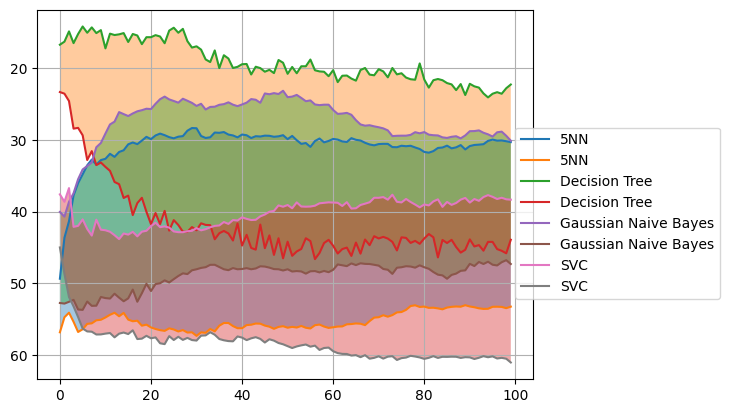

In [140]:
import numpy as np
for key, df in foo.groupby('model'):
    plt.plot(df.min(), label=key)
    plt.plot(df.max(), label=key)
    plt.fill_between(np.arange(df.shape[1]), df.max(), df.min(), alpha=0.4)


plt.grid()
plt.legend(bbox_to_anchor=(0.95, 0.7))
plt.gca().invert_yaxis()

Remove observações para EER, pois só foram feitas para SVM:

In [73]:
df.drop('expected_error_reduction', level='strategy', inplace=True)

## Data Analysis

### SVM

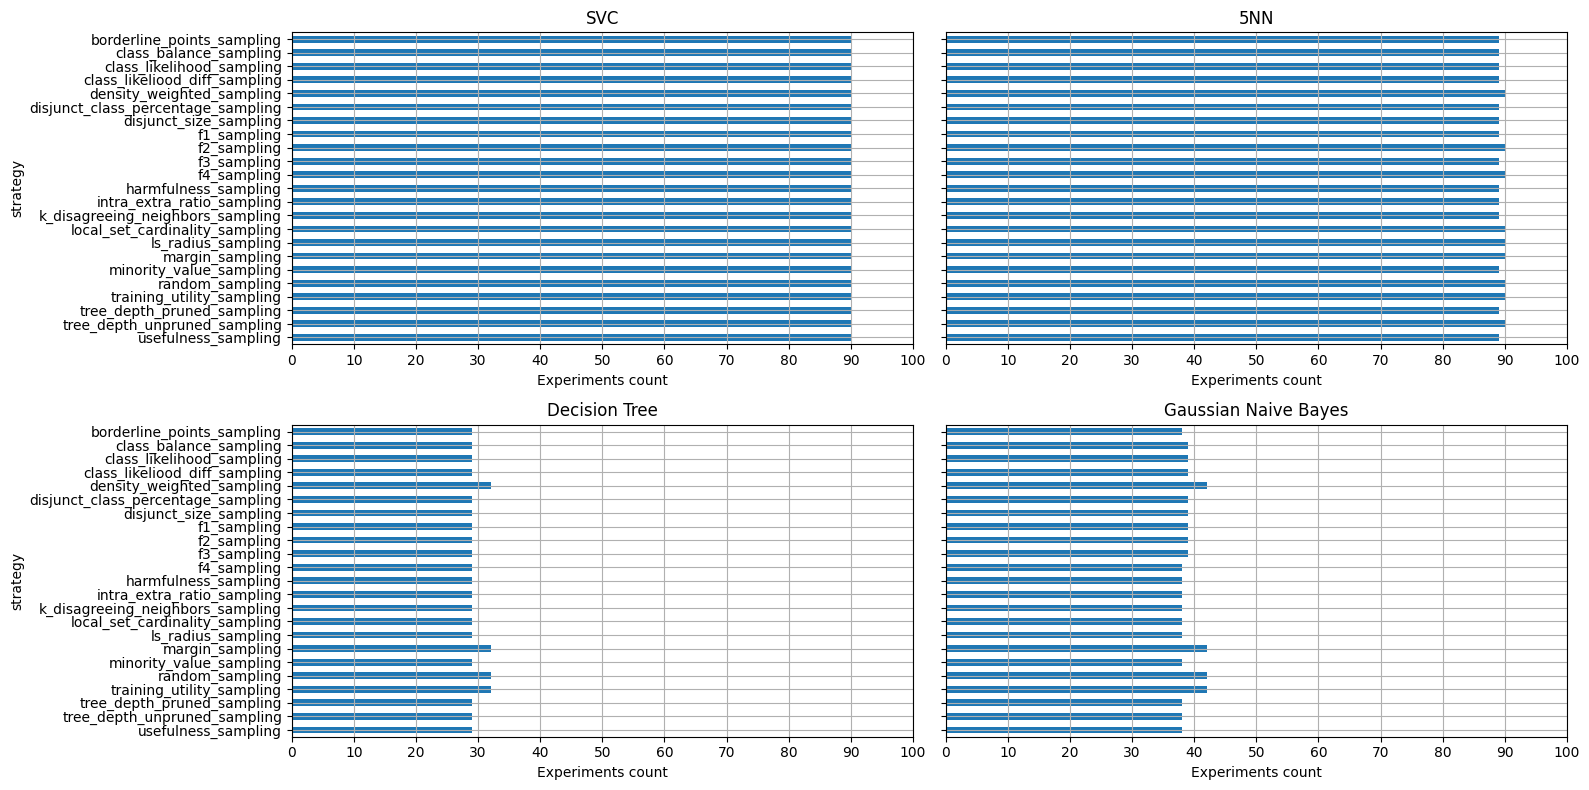

In [101]:
fig, axs = plt.subplots(2,2)

show_counts(df, ax=axs[0, 0], model='SVC')
show_counts(df, ax=axs[0, 1], model='5NN')
show_counts(df, ax=axs[1, 0], model='Decision Tree')
show_counts(df, ax=axs[1, 1], model='Gaussian Naive Bayes')

fig.tight_layout()

## Ranking Curves

### SVC

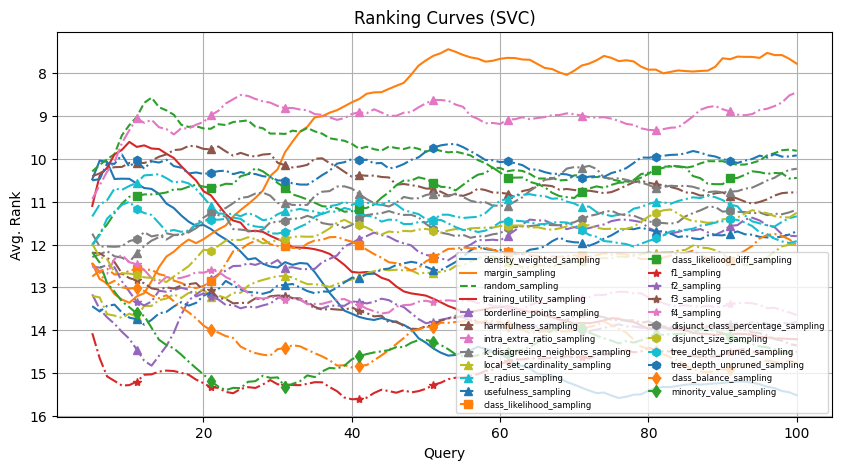

In [74]:
plot_ranking_curves(df, model='SVC')

### KNN

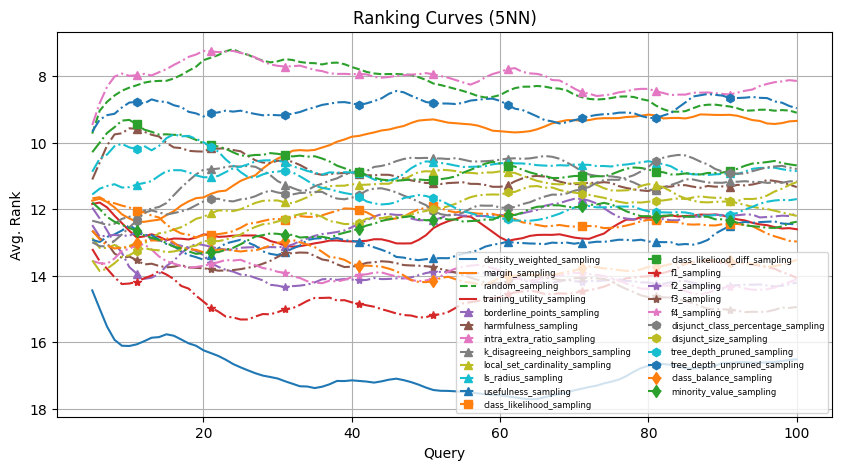

In [70]:
plot_ranking_curves(df, model='5NN')

### Decision Tree

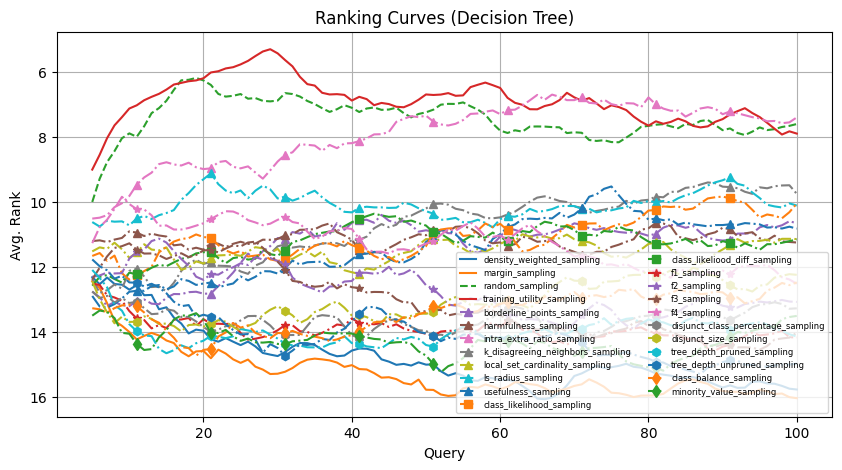

In [71]:
plot_ranking_curves(df, model='Decision Tree')

### Gaussian NB

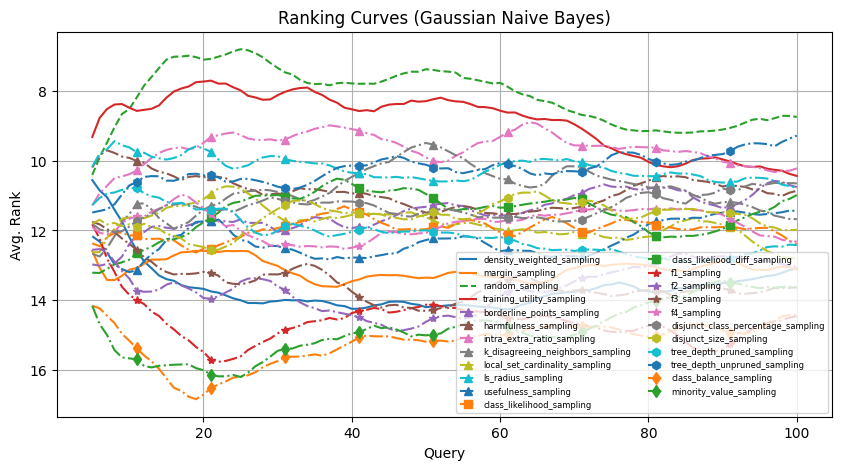

In [72]:
plot_ranking_curves(df, model='Gaussian Naive Bayes')

## Log File

In [28]:
warning_lines = !grep WARNING $LOG_FILE
len(warning_lines)

167620

Produzindo dataframe...

In [29]:
columns = ['time', 'context', 'type', 'msg']
log_df = pd.DataFrame((line.split(' - ') for line in warning_lines),
                     columns=columns)

log_df.context = log_df.context.apply(lambda x: x[1:-1])
log_df[['dataset', 'model', 'strategy']] = log_df.context.str.split(',', expand=True)
log_df.strategy = log_df.strategy.str.strip()

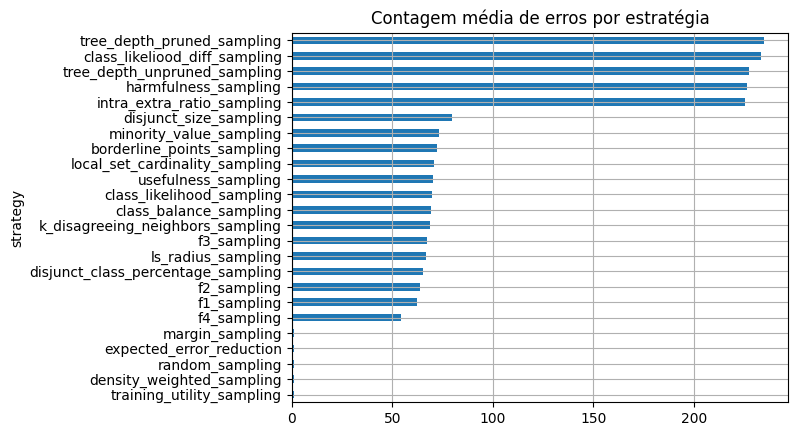

In [30]:
log_df.groupby(['dataset','strategy']).size().groupby('strategy').mean().sort_values().plot(
    kind='barh', grid=True,
    title='Contagem média de erros por estratégia')
plt.show()

In [32]:
log_df.groupby(['dataset','strategy']).size().sort_values(ascending=False)

dataset                         strategy                          
wilt.csv                        class_likeliood_diff_sampling         500
ozone-eighthr.csv               intra_extra_ratio_sampling            500
climate-simulation-craches.csv  intra_extra_ratio_sampling            500
                                harmfulness_sampling                  500
ozone-eighthr.csv               class_likeliood_diff_sampling         500
                                                                     ... 
thyroid-ann.csv                 k_disagreeing_neighbors_sampling        1
volcanoes-e1.csv                disjunct_class_percentage_sampling      1
                                f2_sampling                             1
ecoli.csv                       training_utility_sampling               1
nursery.csv                     training_utility_sampling               1
Length: 1421, dtype: int64

In [ ]:
plot_learning_curves(df, dataset='wilt', classifier='SVC')

### Hardness Sampling

In [33]:
pd.options.display.max_colwidth = 200
pd.DataFrame(log_df.msg.apply(lambda x: x[x.find(']') + 1:]).value_counts()).reset_index()[['count', 'msg']].head(50)

,count,msg
0,16352,"An error occurred while calculating tree_depth_pruned: (RuntimeWarning) ""invalid value encountered in divide"" . Falling back to random sampling."
1,14798,"An error occurred while calculating tree_depth_unpruned: (RuntimeWarning) ""invalid value encountered in divide"" . Falling back to random sampling."
2,14613,"An error occurred while calculating class_likeliood_diff: (ValueError) ""zero-size array to reduction operation maximum which has no identity"" . Falling back to random sampling."
3,14486,"An error occurred while calculating intra_extra_ratio: (IndexError) ""index 0 is out of bounds for axis 0 with size 0"" . Falling back to random sampling."
4,14419,"An error occurred while calculating harmfulness: (RuntimeWarning) ""divide by zero encountered in divide"" . Falling back to random sampling."
5,2277,"An error occurred while calculating tree_depth_unpruned: (UserWarning) ""The least populated class in y has only 1 members, which is less than n_splits=5."" . Falling back to random sampling."
6,2198,"An error occurred while calculating class_likeliood_diff: (UserWarning) ""The least populated class in y has only 1 members, which is less than n_splits=5."" . Falling back to random sampling."
7,2139,"An error occurred while calculating intra_extra_ratio: (UserWarning) ""The least populated class in y has only 1 members, which is less than n_splits=5."" . Falling back to random sampling."
8,2090,"An error occurred while calculating harmfulness: (UserWarning) ""The least populated class in y has only 1 members, which is less than n_splits=5."" . Falling back to random sampling."
9,2050,"An error occurred while calculating ls_radius: (UserWarning) ""The least populated class in y has only 1 members, which is less than n_splits=5."" . Falling back to random sampling."


### Classic Methods

In [34]:
log_df[log_df.strategy.apply(lambda x: x in CLASSIC_METHODS)]

,time,context,type,msg,dataset,model,strategy
32070,"2024-06-06 21:43:14,265","lymphography.csv, SVC, random_sampling",WARNING,"The least populated class in y has only 2 members, which is less than n_splits=5.",lymphography.csv,SVC,random_sampling
32072,"2024-06-06 21:43:15,547","lymphography.csv, SVC, margin_sampling",WARNING,"The least populated class in y has only 2 members, which is less than n_splits=5.",lymphography.csv,SVC,margin_sampling
32073,"2024-06-06 21:43:20,823","lymphography.csv, SVC, density_weighted_sampling",WARNING,"The least populated class in y has only 2 members, which is less than n_splits=5.",lymphography.csv,SVC,density_weighted_sampling
32075,"2024-06-06 21:43:22,993","lymphography.csv, SVC, training_utility_sampling",WARNING,"The least populated class in y has only 2 members, which is less than n_splits=5.",lymphography.csv,SVC,training_utility_sampling
32077,"2024-06-06 21:43:29,315","lymphography.csv, SVC, expected_error_reduction",WARNING,"The least populated class in y has only 2 members, which is less than n_splits=5.",lymphography.csv,SVC,expected_error_reduction
35642,"2024-06-06 23:19:28,703","nursery.csv, SVC, random_sampling",WARNING,"The least populated class in y has only 2 members, which is less than n_splits=5.",nursery.csv,SVC,random_sampling
35645,"2024-06-06 23:19:44,442","nursery.csv, SVC, margin_sampling",WARNING,"The least populated class in y has only 2 members, which is less than n_splits=5.",nursery.csv,SVC,margin_sampling
35646,"2024-06-06 23:19:51,191","nursery.csv, SVC, density_weighted_sampling",WARNING,"The least populated class in y has only 2 members, which is less than n_splits=5.",nursery.csv,SVC,density_weighted_sampling
35648,"2024-06-06 23:19:53,510","nursery.csv, SVC, training_utility_sampling",WARNING,"The least populated class in y has only 2 members, which is less than n_splits=5.",nursery.csv,SVC,training_utility_sampling
35652,"2024-06-06 23:20:29,557","nursery.csv, SVC, expected_error_reduction",WARNING,"The least populated class in y has only 2 members, which is less than n_splits=5.",nursery.csv,SVC,expected_error_reduction
